In [167]:
import os                                                   # to set current working directory 
import math                                                 # basic calculations like square root
from sklearn.neighbors import KNeighborsRegressor           # for nearest k neighbours
from sklearn import metrics                                 # measures to check our models
from sklearn.model_selection import cross_val_score         # cross validation methods
import pandas as pd                                         # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting
from subprocess import check_call
from sklearn.model_selection import train_test_split        # train and test split
import seaborn as sns

In [284]:
# Define a couple of functions to streamline plotting correlation matrices and visualization of a decision tree regression model

def plot_corr(dataframe,size=10):                               # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,plot_step):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    
def check_model_train(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))
    
def check_model_test(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Testing = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

In [241]:
df=pd.read_csv("cretaceous_wells.csv")
df

,Unnamed: 0,Company Number,Formation,Surface northing,Bottom hole northing,Surface easting,Bottom hole easting,Number of frac stages,Total slurry (bbl),Total proppant (lb),Lateral length (ft),Lateral azimuth (),IP oil (bbl),IP GOR,Cumulative oil (bbl),Cumulative days,IP oil API gravity ()
0,0,26,Turner,1.101721,1.101830,1.051392,1.051227,NaN,NaN,NaN,3831,75,96.0,0.0,784,185,NaN
1,1,9,Turner,1.091999,1.092278,1.056680,1.056723,NaN,NaN,125124.0,3533,339,NaN,NaN,116902,1590,NaN
2,2,8,Turner,1.088332,1.088023,1.054312,1.054274,12.0,NaN,1992847.0,3754,163,472.0,7.5,157218,3024,52.2
3,3,8,Turner,1.088317,1.088018,1.054622,1.054559,13.0,36638.0,1992421.0,4000,152,183.0,11.0,109167,2832,NaN
4,4,8,Turner,1.088386,1.088670,1.054247,1.054335,13.0,NaN,2027081.0,4072,322,232.0,9.1,79701,2634,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,588,13,Codell,1.032579,1.032525,1.044837,1.045051,30.0,70751.0,3629948.0,5907,264,120.0,417.0,46978,493,40.0
589,589,13,Codell,1.034007,1.033977,1.045773,1.045409,51.0,118753.0,5671315.0,9985,92,117.0,410.0,28421,448,40.0
590,590,24,Codell,1.030057,1.030782,1.046623,1.046603,55.0,322829.0,19622283.0,10691,4,888.0,551.0,41540,60,35.2
591,591,24,Codell,1.030057,1.030781,1.046621,1.046577,55.0,327633.0,19462453.0,10742,9,1192.0,688.0,46612,53,35.2


In [242]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,593.0,2.960000e+02,1.713286e+02,0.000000,1.480000e+02,2.960000e+02,4.440000e+02,5.920000e+02
Company Number,593.0,1.212310e+01,7.346862e+00,0.000000,8.000000e+00,8.000000e+00,1.700000e+01,3.100000e+01
Surface northing,593.0,1.076301e+00,2.401768e-02,1.025082,1.078218e+00,1.087650e+00,1.091249e+00,1.101721e+00
Bottom hole northing,593.0,1.076297e+00,2.400690e-02,1.025091,1.078218e+00,1.087584e+00,1.091265e+00,1.101830e+00
Surface easting,593.0,1.053477e+00,4.696932e-03,1.043355,1.049147e+00,1.054833e+00,1.056656e+00,1.064332e+00
Bottom hole easting,593.0,1.053474e+00,4.691363e-03,1.043403,1.049049e+00,1.054815e+00,1.056674e+00,1.064400e+00
Number of frac stages,566.0,2.544700e+01,1.359541e+01,3.000000,1.400000e+01,2.000000e+01,3.575000e+01,7.300000e+01
Total slurry (bbl),436.0,1.645627e+05,4.980917e+05,3695.000000,5.314950e+04,8.892000e+04,1.539485e+05,5.417399e+06
Total proppant (lb),573.0,5.980083e+06,4.574828e+06,71078.000000,2.923660e+06,4.289660e+06,7.586097e+06,2.568045e+07
Lateral length (ft),593.0,5.905464e+03,2.739058e+03,20.000000,3.865000e+03,4.363000e+03,9.037000e+03,1.089700e+04


In [243]:
df['Average Daily Production'] = df['Cumulative oil (bbl)']/df['Cumulative days']/df['Lateral length (ft)']*1000000
df

,Unnamed: 0,Company Number,Formation,Surface northing,Bottom hole northing,Surface easting,Bottom hole easting,Number of frac stages,Total slurry (bbl),Total proppant (lb),Lateral length (ft),Lateral azimuth (),IP oil (bbl),IP GOR,Cumulative oil (bbl),Cumulative days,IP oil API gravity (),Average Daily Production
0,0,26,Turner,1.101721,1.101830,1.051392,1.051227,NaN,NaN,NaN,3831,75,96.0,0.0,784,185,NaN,1106.196251
1,1,9,Turner,1.091999,1.092278,1.056680,1.056723,NaN,NaN,125124.0,3533,339,NaN,NaN,116902,1590,NaN,20810.436015
2,2,8,Turner,1.088332,1.088023,1.054312,1.054274,12.0,NaN,1992847.0,3754,163,472.0,7.5,157218,3024,52.2,13849.248632
3,3,8,Turner,1.088317,1.088018,1.054622,1.054559,13.0,36638.0,1992421.0,4000,152,183.0,11.0,109167,2832,NaN,9636.917373
4,4,8,Turner,1.088386,1.088670,1.054247,1.054335,13.0,NaN,2027081.0,4072,322,232.0,9.1,79701,2634,NaN,7430.879701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,588,13,Codell,1.032579,1.032525,1.044837,1.045051,30.0,70751.0,3629948.0,5907,264,120.0,417.0,46978,493,40.0,16131.718445
589,589,13,Codell,1.034007,1.033977,1.045773,1.045409,51.0,118753.0,5671315.0,9985,92,117.0,410.0,28421,448,40.0,6353.503469
590,590,24,Codell,1.030057,1.030782,1.046623,1.046603,55.0,322829.0,19622283.0,10691,4,888.0,551.0,41540,60,35.2,64758.519627
591,591,24,Codell,1.030057,1.030781,1.046621,1.046577,55.0,327633.0,19462453.0,10742,9,1192.0,688.0,46612,53,35.2,81872.248940


In [244]:
# # Standardize data
# from sklearn.preprocessing import StandardScaler 
# scaler = StandardScaler()                                   # instantiate the scaler 
# stdfeatures = scaler.fit_transform(df.iloc[:,[4,6]])                  # standardize all the values except production 

# df['Surface northing'] = stdfeatures[:,0]
# df['Surface easting'] = stdfeatures[:,1]

# df.describe().transpose()

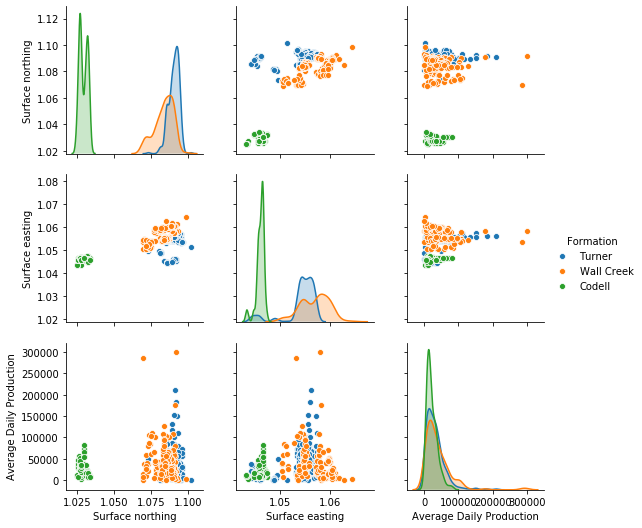

In [283]:
sns.pairplot(df.iloc[:,[3,5,-1,2]], hue = "Formation")

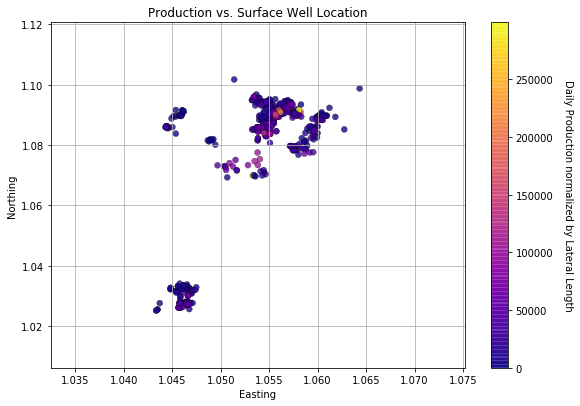

In [376]:
plt.subplot(111)
im = plt.scatter(df["Surface easting"],df["Surface northing"],s=None, c=df['Average Daily Production'], marker=None, cmap='plasma', norm=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Production vs. Surface Well Location'); plt.xlabel('Easting'); plt.ylabel('Northing')
# plt.xlim(1.045,1.06); plt.ylim(1.02,1.1)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Daily Production normalized by Lateral Length", rotation=270, labelpad=20)
plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

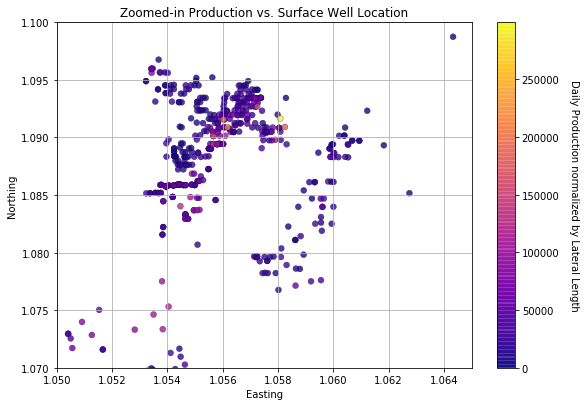

In [324]:
plt.subplot(111)
im = plt.scatter(df["Surface easting"],df["Surface northing"],s=None, c=df['Average Daily Production'], marker=None, cmap='plasma', norm=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Zoomed-in Production vs. Surface Well Location'); plt.xlabel('Easting'); plt.ylabel('Northing')
plt.xlim(1.05,1.065); plt.ylim(1.07,1.1)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Daily Production normalized by Lateral Length", rotation=270, labelpad=20)
plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [377]:
# Filter to highest production wells
northmin = 1.08; northmax = 1.095;
eastmin = 1.054; eastmax = 1.062;
df_filter = df[(df['Surface northing']>northmin) & (df['Surface northing']<northmax)]
df_filter = df_filter[(df_filter['Surface easting']>eastmin) & (df_filter['Surface easting']<eastmax)]
df_filter.shape

(344, 18)

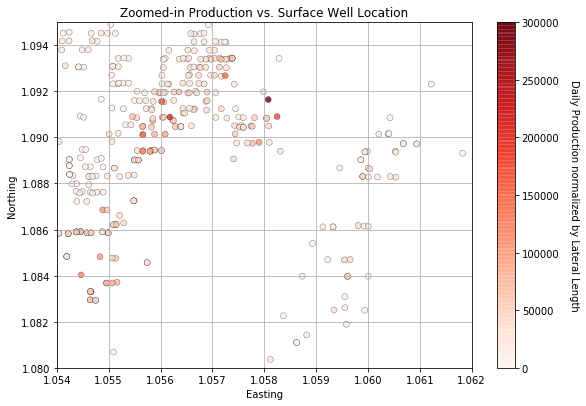

In [384]:
plt.subplot(111)
im = plt.scatter(df["Surface easting"],df["Surface northing"],s=None, c=df['Average Daily Production'], marker=None, cmap='Reds', norm=None, vmin=prodmin, vmax=prodmax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Zoomed-in Production vs. Surface Well Location'); plt.xlabel('Easting'); plt.ylabel('Northing')
plt.xlim(eastmin,eastmax); plt.ylim(northmin,northmax)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Daily Production normalized by Lateral Length", rotation=270, labelpad=20)
plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [409]:
# Another round of Filtering
northmin = 1.088; northmax = 1.094;
eastmin = 1.055; eastmax = 1.059;
df_filter = df[(df['Surface northing']>northmin) & (df['Surface northing']<northmax)]
df_filter = df_filter[(df_filter['Surface easting']>eastmin) & (df_filter['Surface easting']<eastmax)]
df_filter.shape

(174, 18)

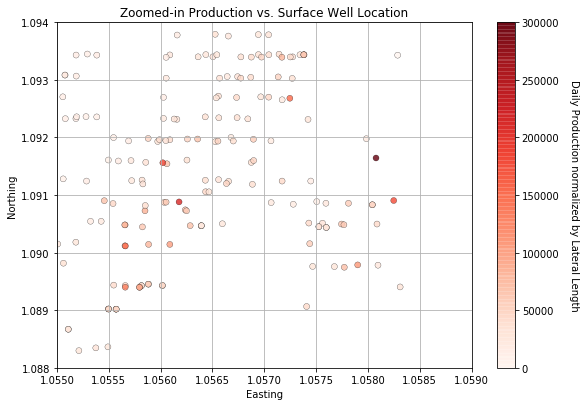

In [410]:
plt.subplot(111)
im = plt.scatter(df["Surface easting"],df["Surface northing"],s=None, c=df['Average Daily Production'], marker=None, cmap='Reds', norm=None, vmin=prodmin, vmax=prodmax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Zoomed-in Production vs. Surface Well Location'); plt.xlabel('Easting'); plt.ylabel('Northing')
plt.xlim(eastmin,eastmax); plt.ylim(northmin,northmax)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Daily Production normalized by Lateral Length", rotation=270, labelpad=20)
plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

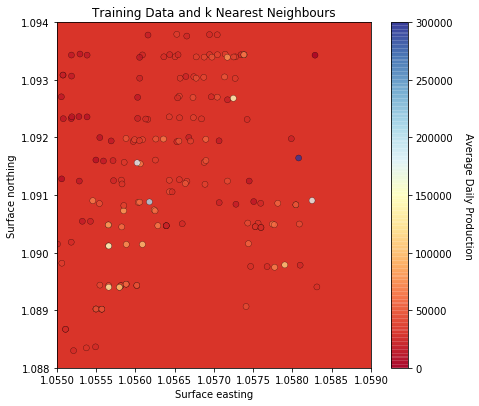

In [440]:
df_subset = df_filter.loc[:,['Surface northing','Surface easting','Average Daily Production']]
X = df_subset.iloc[:,:2]
y = df_subset.iloc[:,-1]

neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=1, p = 2) # instantiate the prediction model
neigh_fit = neigh.fit(X,y)              # train the model with the training data

plt.subplot(122)
visualize_model(neigh_fit,X["Surface easting"],eastmin,eastmax,X["Surface northing"],northmin,northmax,y,prodmin,prodmax,'Training Data and k Nearest Neighbours',0.00001)
plt.xlim(eastmin,eastmax); plt.ylim(northmin,northmax)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [434]:
df_subset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Surface northing,174.0,1.091446,0.001446,1.088298,1.090467,1.091411,1.092695,1.093790
Surface easting,174.0,1.056420,0.000853,1.055008,1.055717,1.056393,1.057060,1.058311
Average Daily Production,174.0,44750.427984,37140.637035,0.000000,25864.511464,35401.031639,49624.122236,299544.591211


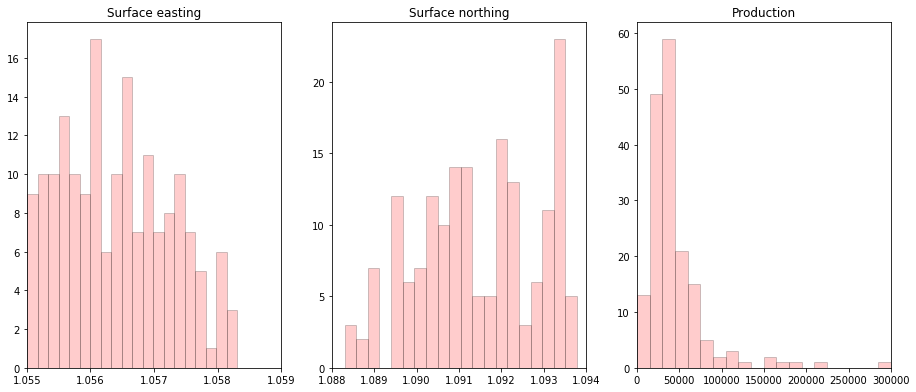

In [417]:
plt.subplot(131)
plt.hist(X["Surface easting"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Surface easting'); plt.xlim(eastmin,eastmax)

plt.subplot(132)
plt.hist(X["Surface northing"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Surface northing'); plt.xlim(northmin,northmax)

plt.subplot(133)
plt.hist(y, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Production'); plt.xlim(prodmin,prodmax)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [430]:
# Standardize data
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()                                   # instantiate the scaler 
stdfeatures = scaler.fit_transform(df_subset)                  # standardize all the values except production 
variables = df_subset.columns.values
df_std = pd.DataFrame(stdfeatures, columns=variables)        # instantiate a new DataFrame
df_std.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Surface northing,174.0,1.503523e-14,1.002886,-2.182363,-0.678487,-0.024038,0.866127,1.625497
Surface easting,174.0,-1.304627e-13,1.002886,-1.659006,-0.825898,-0.031926,0.752614,2.222880
Average Daily Production,174.0,-1.174029e-16,1.002886,-1.208369,-0.509965,-0.252456,0.131601,6.880052


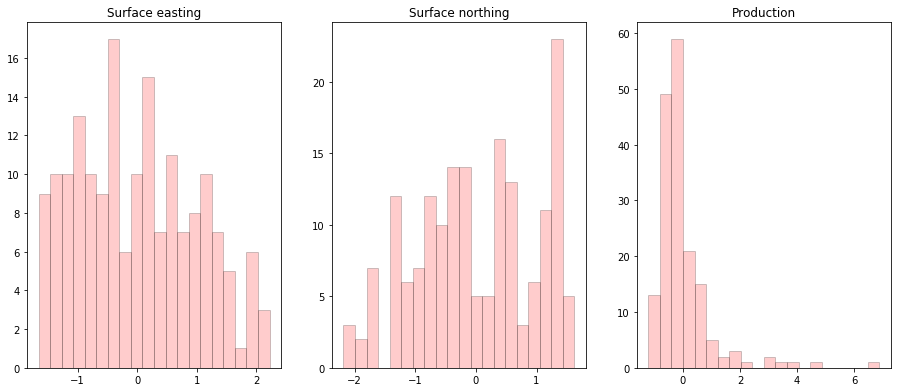

In [432]:
X = df_std.iloc[:,:2]
y = df_std.iloc[:,-1]

plt.subplot(131)
plt.hist(X["Surface easting"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Surface easting')

plt.subplot(132)
plt.hist(X["Surface northing"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Surface northing')

plt.subplot(133)
plt.hist(y, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Production')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

### Ignore below

(344, 18)

In [345]:
df_subset = df_filter.loc[:,['Surface northing','Surface easting','Average Daily Production']]
df_train, df_test = train_test_split(df_subset, test_size=0.2, random_state=100)

,count,mean,std,min,25%,50%,75%,max
Surface northing,275.0,1.089660,0.003367,1.080363,1.087624,1.090435,1.092321,1.094902
Surface easting,275.0,1.056371,0.001780,1.054041,1.054927,1.056018,1.057267,1.061828
Average Daily Production,275.0,36995.246382,33332.451816,0.000000,15974.008094,30411.319940,46232.430298,299544.591211


In [347]:
df_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Surface northing,69.0,1.089793,0.002981,1.081097,1.088326,1.089816,1.092325,1.094504
Surface easting,69.0,1.056383,0.001835,1.054193,1.055064,1.056029,1.057171,1.060684
Average Daily Production,69.0,37456.562603,29542.398568,4896.064968,15046.592603,25324.436021,58888.807150,152630.380527


In [348]:
# Create individual dataframes for training and testing data
X_train = df_train.iloc[:,:2]
y_train = df_train.iloc[:,-1]
X_test = df_test.iloc[:,:2]
y_test = df_test.iloc[:,-1]

prodmin = 0; prodmax = 300000

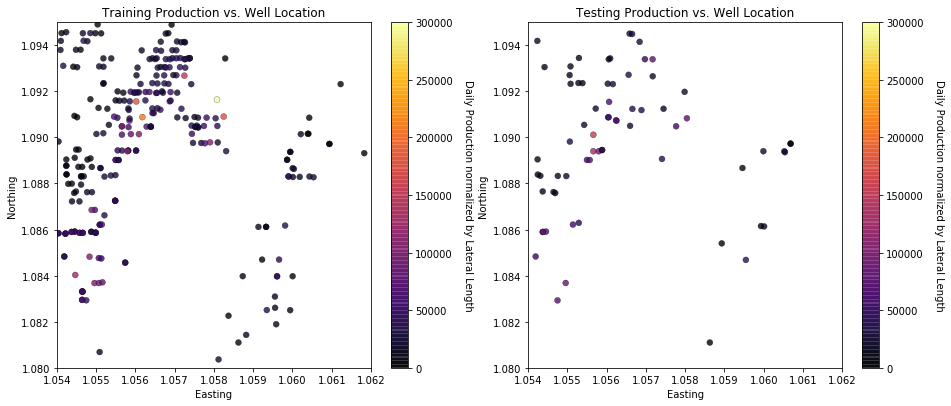

In [354]:
plt.subplot(121)
im = plt.scatter(X_train["Surface easting"],X_train["Surface northing"],s=None, c=y_train, marker=None, cmap='inferno', norm=None, vmin=prodmin, vmax=prodmax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Training Production vs. Well Location'); plt.xlabel('Easting'); plt.ylabel('Northing')
plt.xlim(eastmin,eastmax); plt.ylim(northmin,northmax)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Daily Production normalized by Lateral Length", rotation=270, labelpad=20)

plt.subplot(122)
im = plt.scatter(X_test["Surface easting"],X_test["Surface northing"],s=None, c=y_test, marker=None, cmap='inferno', norm=None, vmin=prodmin, vmax=prodmax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Testing Production vs. Well Location'); plt.xlabel('Easting'); plt.ylabel('Northing')
plt.xlim(eastmin,eastmax); plt.ylim(northmin,northmax)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Daily Production normalized by Lateral Length", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [247]:
# X = df.iloc[:,[3,5]]
# Y = df.iloc[:,[-1]]

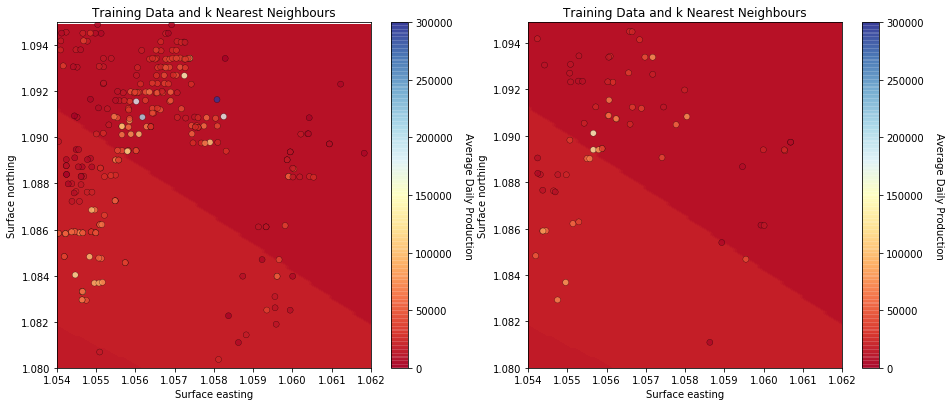

In [374]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=2, p = 2) # instantiate the prediction model
neigh_fit = neigh.fit(X_train,y_train)              # train the model with the training data

plot_step = 0.0001
plt.subplot(121)
visualize_model(neigh_fit,X_train["Surface easting"],eastmin,eastmax,X_train["Surface northing"],northmin,northmax,y_train,prodmin,prodmax,'Training Data and k Nearest Neighbours',plot_step)
plt.xlim(eastmin,eastmax); plt.ylim(northmin,northmax)

plt.subplot(122)
visualize_model(neigh_fit,X_test["Surface easting"],eastmin,eastmax,X_test["Surface northing"],northmin,northmax,y_test,prodmin,prodmax,'Training Data and k Nearest Neighbours',plot_step)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

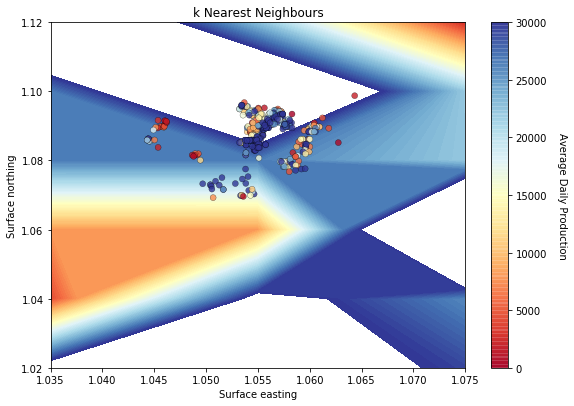

In [288]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=2, p = 2) # instantiate the prediction model
neigh_fit = neigh.fit(X,Y)              # train the model with the training data

plt.subplot(111)
visualize_model(neigh_fit,X['Surface easting'],1.035,1.08,X['Surface northing'],1.02,1.12,Y['Average Daily Production'],0,30000,'k Nearest Neighbours',0.02)
# visualize_model(neigh_fit,X_train["Por"],-3.5,3.5,X_train["Brittle"],-3.5,3.5,y_train,prodmin,prodmax,'Training Data and k Nearest Neighbours',0.02)


plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [261]:
X = df3.iloc[:,[3,5]]
Y = df3.iloc[:,[-1]]
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Surface northing,473.0,1.088013,0.005614,1.069241,1.085750,1.089404,1.091968,1.098735
Surface easting,473.0,1.055323,0.003254,1.044316,1.054247,1.055498,1.057136,1.064332


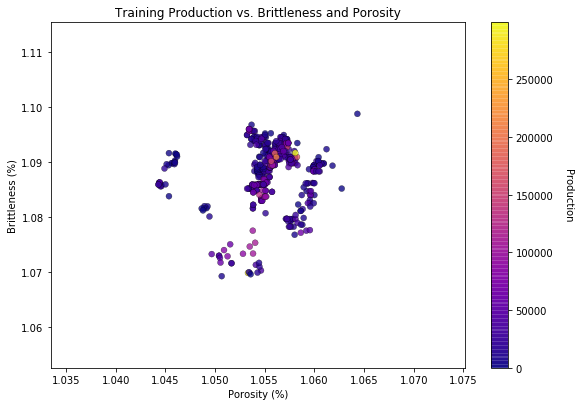

In [269]:
plt.subplot(111)
im = plt.scatter(X["Surface easting"],X["Surface northing"],s=None, c=Y['Average Daily Production'], marker=None, cmap='plasma', norm=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Training Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
# plt.xlim(-3,3); plt.ylim(-3,3)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [271]:
# Standardize data
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()                                   # instantiate the scaler 
stdfeatures = scaler.fit_transform(X)                  # standardize all the values except production 
variables = X.columns.values

X_std = pd.DataFrame(stdfeatures, columns=variables)        # instantiate a new DataFrame
X_std.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Surface northing,473.0,-5.521975e-14,1.001059,-3.347265,-0.403494,0.247944,0.705118,1.911797
Surface easting,473.0,-2.444181e-14,1.001059,-3.386563,-0.331095,0.053719,0.557667,2.771817


In [441]:
# neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=2, p = 2) # instantiate the prediction model
# neigh_fit = neigh.fit(X,Y)              # train the model with the training data

# plt.subplot(111)
# visualize_model(neigh_fit,X_std['Surface easting'],-3.5,3,X_std['Surface northing'],-3.5,3,Y['Average Daily Production'],Y.min(),Y.max(),'k Nearest Neighbours',0.005)
# # visualize_model(neigh_fit,X_train["Por"],-3.5,3.5,X_train["Brittle"],-3.5,3.5,y_train,prodmin,prodmax,'Training Data and k Nearest Neighbours')


# plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
# plt.show()